In [1]:
#不运行这个kernel在运行softmax时会自动restart（不知道为啥
%env MKL_THREADING_LAYER=SEQUENTIAL
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1


env: MKL_THREADING_LAYER=SEQUENTIAL
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [2]:
import numpy as np
from dataclasses import dataclass
from typing import List
import random
import scipy.optimize as opt
import scipy.linalg as sla


In [3]:
@dataclass
class Dataset:
    Xtr: np.ndarray  
    Str: np.ndarray  
    Xts: np.ndarray  
    Yts: np.ndarray  

def load_npz(path): 
    d=np.load(path); 
    return Dataset(d['Xtr'],d['Str'],d['Xts'],d['Yts'])

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

def softmax(z: np.ndarray) -> np.ndarray:
    z = z - z.max(axis=1, keepdims=True)       
    expz = np.exp(z)
    return expz / (expz.sum(axis=1, keepdims=True) + 1e-12)

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())
    
def standardize(X):
    X = X.astype(np.float32)
    if X.max() > 1.5:
        X /= 255.0
    mu = X.mean(axis=0, keepdims=True)
    sg = X.std(axis=0, keepdims=True) + 1e-6
    return (X - mu) / sg

# 1 Anchor Classifier 初步分类器

## 1.1 Softmax

In [4]:
class SoftmaxAnchor:
    def __init__(self, in_dim: int, num_classes: int,
                 lr: float = 0.02, weight_decay: float = 5e-4,
                 label_smoothing: float = 0.0):
        self.C = num_classes
        self.W = 0.01 * np.random.randn(in_dim, num_classes).astype(np.float32)
        self.b = np.zeros((num_classes,), dtype=np.float32)
        self.lr = lr
        self.wd = weight_decay
        self.eps = float(label_smoothing)

    def _forward(self, X):
        logits = X @ self.W + self.b
        return softmax(logits)  #

    def _loss_and_grads(self, X, y):
        N = X.shape[0]
        P = self._forward(X)                              # (N, C)

        if self.eps > 0.0:
            # one-hot with smoothing
            Y = np.zeros_like(P); Y[np.arange(N), y] = 1.0
            Y = (1 - self.eps) * Y + self.eps / self.C
            # cross-entropy with probs targets
            loss = -(Y * np.log(P + 1e-12)).sum(axis=1).mean()
            G = (P - Y) / N
        else:
            loss = -np.log(P[np.arange(N), y] + 1e-12).mean()
            G = P; G[np.arange(N), y] -= 1.0
            G /= N

        if self.wd > 0:
            loss += 0.5 * self.wd * np.sum(self.W * self.W)

        dW = X.T @ G + self.wd * self.W
        db = G.sum(axis=0)
        return loss, dW, db

    def fit(self, X, y, epochs=1, batch_size=256, verbose=False, seed=0):
        set_seed(seed)
        N = X.shape[0]
        for _ in range(epochs):
            idx = np.random.permutation(N)
            Xs, ys = X[idx], y[idx]
            for st in range(0, N, batch_size):
                ed = min(st + batch_size, N)
                loss, dW, db = self._loss_and_grads(Xs[st:ed], ys[st:ed])
                self.W -= self.lr * dW
                self.b -= self.lr * db
            if verbose:
                print(f"[Softmax Anchor] loss={loss:.4f} | train_acc={self.score(X, y):.3f}")

    def predict_proba(self, X):  return self._forward(X)
    def predict(self, X):        return np.argmax(self._forward(X), axis=1)
    def score(self, X, y):       return accuracy(y, self.predict(X))

In [5]:
def train_anchor_with_diag_earlystop(model, X_std, y, top_pct=0.40,
                                     max_epochs=10, patience=2, batch_size=512, seed=0):
    import copy
    best_model, best_diag, best_ep = None, -1.0, 0
    wait = 0
    for ep in range(1, max_epochs + 1):
        model.fit(X_std, y, epochs=1, batch_size=batch_size, verbose=False, seed=seed)
        P = model.predict_proba(X_std)
        T_hat, _ = estimate_T_from_probs(P, y, top_pct=top_pct, use_counts=True, verbose=False)
        diag_mean = float(np.diag(T_hat).mean())
        print(f"[ep {ep:02d}] train_acc={model.score(X_std, y):.3f} | diag_mean(T)={diag_mean:.4f}")

        if diag_mean > best_diag:
            best_diag, best_ep = diag_mean, ep
            best_model = copy.deepcopy(model)
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    print(f"BEST epoch {best_ep} (diag_mean={best_diag:.4f})")
    return best_model, best_diag

# 2 T估计器

## 2.1 选前百分之多少的样本作为锚点

In [6]:
def select_anchors_topk(probs: np.ndarray, top_pct: float = 0.01):
    N, C = probs.shape
    k = max(1, int(np.ceil(top_pct * N)))
    anchors = []
    for i in range(C):
        idx = np.argsort(probs[:, i])[-k:]  
        anchors.append(idx)
    return anchors


## 2.2 估计 T 的每一行（两种常见法：概率平均 / 计数直方图）

In [7]:
#  Estimate the transition matrix T using anchor samples.
#     - Mean-probability method (use_counts=False): average the model probabilities over anchor samples within each class.
#     - Counting method (use_counts=True): compute the noisy label frequencies within each anchor group.
def estimate_T_anchor(probs: np.ndarray,
                      noisy_labels: np.ndarray,
                      anchors: list,
                      use_counts: bool = False,
                      eps: float = 1e-6) -> np.ndarray:
    N, C = probs.shape
    T_hat = np.zeros((C, C), dtype=np.float32)
    for i in range(C):
        idx = anchors[i]
        if len(idx) == 0:
            row = np.zeros(C, dtype=np.float32); row[i] = 1.0
        else:
            if use_counts:
                hist = np.bincount(noisy_labels[idx], minlength=C).astype(np.float32)
                row = hist / (hist.sum() + eps)
            else:
                row = probs[idx].mean(axis=0).astype(np.float32)
                row = row / (row.sum() + eps)
        row = np.clip(row, eps, 1.0)
        row = row / row.sum()
        T_hat[i] = row
    return T_hat

def estimate_T_from_probs(probs: np.ndarray,
                          noisy_labels: np.ndarray,
                          top_pct: float = 0.01,
                          use_counts: bool = False,
                          verbose: bool = True):

    assert probs.shape[0] == noisy_labels.shape[0], "probs and noisy_labels must have the same length"
    C = probs.shape[1]

    # Select anchor samples
    anchors = select_anchors_topk(probs, top_pct=top_pct)
    if verbose:
        cnts = [len(a) for a in anchors]
        print(f"[Anchor] top_pct={top_pct:.4f}, per-class counts={cnts}")

     # Estimate transition matrix
    T_hat = estimate_T_anchor(probs, noisy_labels, anchors, use_counts=use_counts)

     # Print row sums for sanity check
    if verbose:
        row_sums = T_hat.sum(axis=1)
        print("[T_hat] row sums:", np.round(row_sums, 6))

        def smart_round(x):
            s = f"{x:.4f}".rstrip('0').rstrip('.')
            return s if s != '' else '0'

        print("T_hat:\n", np.array2string(
            T_hat, formatter={'float_kind': smart_round}, separator=' '))

    return T_hat, anchors

# 3 看初步分类器在数据集上的准确率

In [8]:
data1 = load_npz("datasets/FashionMNIST0.3.npz")
data2 = load_npz("datasets/FashionMNIST0.6.npz")
data3 = load_npz("datasets/CIFAR.npz")

# FashionMNIST0.3（train+val)
X_1 = data1.Xtr.reshape(len(data1.Xtr), -1)
y_1 = data1.Str
X_1_std = standardize(X_1)
in_dim_1 = X_1_std.shape[1]

# FashionMNIST0.6
X_2 = data2.Xtr.reshape(len(data2.Xtr), -1)
y_2 = data2.Str
X_2_std = standardize(X_2)
in_dim_2 = X_2_std.shape[1]

# CIFAR
X_3 = data3.Xtr.reshape(len(data3.Xtr), -1)
y_3 = data3.Str
X_3_std = standardize(X_3)
in_dim_3 = X_3_std.shape[1]
print(X_1.shape)

(18000, 784)


In [9]:
# anchor_1 = SoftmaxAnchor(in_dim_1, num_classes=3, lr=0.02, weight_decay=5e-4, label_smoothing=0.05)

# best_anchor_1, best_diag_1 = train_anchor_with_diag_earlystop(anchor_1, X_1_std, y_1, top_pct=0.40,
#                                                max_epochs=20, patience=2, batch_size=512, seed=0)

from itertools import product

alpha = 0.40            # for early-stopping
max_epochs = 10
patience = 2
batch_size = 512

grid_ls  = [0.05, 0.10, 0.15]        # label_smoothing
grid_wd  = [5e-4, 1e-3, 2e-3]        # weight_decay
grid_lr  = [0.01, 0.02]              # learning rate

results = []   

for ls, wd, lr in product(grid_ls, grid_wd, grid_lr):
    print(f"\n=== Try: ls={ls}, wd={wd}, lr={lr} ===")
    model = SoftmaxAnchor(in_dim_1, num_classes=3, lr=lr, weight_decay=wd, label_smoothing=ls)
    best_model, best_diag = train_anchor_with_diag_earlystop(
        model, X_1_std, y_1,
        top_pct=alpha, max_epochs=max_epochs, patience=patience,
        batch_size=batch_size, seed=0
    )

    results.append({
        "label_smoothing": ls,
        "weight_decay": wd,
        "lr": lr,
        "best_diag_mean": float(best_diag),
        "best_model": best_model
    })

results_sorted = sorted(results, key=lambda r: r["best_diag_mean"], reverse=True)
print("\n====== Grid Search Summary (sorted by best_diag_mean desc) ======")
for r in results_sorted:
    print(f"ls={r['label_smoothing']:.2f} | wd={r['weight_decay']:.1e} | lr={r['lr']:.2f} "
          f"| best_diag_mean={r['best_diag_mean']:.4f}")

best_cfg_1 = results_sorted[0]
best_anchor_1 = best_cfg_1["best_model"]
print(f"\n BEST cfg -> ls={best_cfg_1['label_smoothing']}, wd={best_cfg_1['weight_decay']}, "
      f"lr={best_cfg_1['lr']}, best_diag_mean={best_cfg_1['best_diag_mean']:.4f}")



=== Try: ls=0.05, wd=0.0005, lr=0.01 ===
[ep 01] train_acc=0.654 | diag_mean(T)=0.6136
[ep 02] train_acc=0.656 | diag_mean(T)=0.6154
[ep 03] train_acc=0.659 | diag_mean(T)=0.6173
[ep 04] train_acc=0.661 | diag_mean(T)=0.6195
[ep 05] train_acc=0.663 | diag_mean(T)=0.6205
[ep 06] train_acc=0.665 | diag_mean(T)=0.6210
[ep 07] train_acc=0.666 | diag_mean(T)=0.6225
[ep 08] train_acc=0.667 | diag_mean(T)=0.6233
[ep 09] train_acc=0.668 | diag_mean(T)=0.6238
[ep 10] train_acc=0.669 | diag_mean(T)=0.6246
BEST epoch 10 (diag_mean=0.6246)

=== Try: ls=0.05, wd=0.0005, lr=0.02 ===
[ep 01] train_acc=0.644 | diag_mean(T)=0.6092
[ep 02] train_acc=0.649 | diag_mean(T)=0.6130
[ep 03] train_acc=0.652 | diag_mean(T)=0.6159
[ep 04] train_acc=0.653 | diag_mean(T)=0.6182
[ep 05] train_acc=0.655 | diag_mean(T)=0.6196
[ep 06] train_acc=0.658 | diag_mean(T)=0.6204
[ep 07] train_acc=0.661 | diag_mean(T)=0.6212
[ep 08] train_acc=0.662 | diag_mean(T)=0.6220
[ep 09] train_acc=0.663 | diag_mean(T)=0.6226
[ep 10] t

In [10]:
# ==== FashionMNIST0.6 (use FashionMNIST0.3 config) ====
anchor_2 = SoftmaxAnchor(in_dim_2, num_classes=3,lr=0.01, weight_decay=0.0005, label_smoothing=0.15)

best_anchor_2, best_diag_2 = train_anchor_with_diag_earlystop(
    anchor_2, X_2_std, y_2,
    top_pct=0.40,        
    max_epochs=10,        
    patience=2,
    batch_size=512,
    seed=0
)
print(f"\n FashionMNIST | best diag_mean(T) = {best_diag_2:.4f}")

[ep 01] train_acc=0.353 | diag_mean(T)=0.3526
[ep 02] train_acc=0.361 | diag_mean(T)=0.3584
[ep 03] train_acc=0.365 | diag_mean(T)=0.3633
[ep 04] train_acc=0.369 | diag_mean(T)=0.3678
[ep 05] train_acc=0.374 | diag_mean(T)=0.3724
[ep 06] train_acc=0.378 | diag_mean(T)=0.3745
[ep 07] train_acc=0.380 | diag_mean(T)=0.3785
[ep 08] train_acc=0.383 | diag_mean(T)=0.3805
[ep 09] train_acc=0.387 | diag_mean(T)=0.3823
[ep 10] train_acc=0.389 | diag_mean(T)=0.3842
BEST epoch 10 (diag_mean=0.3842)

 FashionMNIST | best diag_mean(T) = 0.3842


In [11]:
# ==== CIFAR (no true T, use FashionMNIST0.3 config) ====
anchor_3 = SoftmaxAnchor(in_dim=in_dim_3,num_classes=3,lr=0.01,weight_decay=5e-4,label_smoothing=0.15)

best_anchor_3, best_diag_3 = train_anchor_with_diag_earlystop(
    anchor_3, X_3_std, y_3,
    top_pct=0.40,        
    max_epochs=10,
    patience=2,
    batch_size=512,
    seed=0
)
print(f"\n CIFAR | best diag_mean(T) = {best_diag_3:.4f}")

[ep 01] train_acc=0.356 | diag_mean(T)=0.3470
[ep 02] train_acc=0.358 | diag_mean(T)=0.3593
[ep 03] train_acc=0.361 | diag_mean(T)=0.3563
[ep 04] train_acc=0.360 | diag_mean(T)=0.3598
[ep 05] train_acc=0.362 | diag_mean(T)=0.3667
[ep 06] train_acc=0.364 | diag_mean(T)=0.3612
[ep 07] train_acc=0.367 | diag_mean(T)=0.3631
BEST epoch 5 (diag_mean=0.3667)

 CIFAR | best diag_mean(T) = 0.3667


# 4 估计前2个数据集的T，比对

In [12]:
import numpy as np
# Evaluate the quality of estimated transition matrix T_hat against ground truth T_true
def evaluate_T(T_hat: np.ndarray, T_true: np.ndarray, verbose: bool = True):
    assert T_hat.shape == T_true.shape, "T_hat.shape != T_true"
    diff = T_hat - T_true
    per_row_L1 = np.sum(np.abs(diff), axis=1)
    frob = np.linalg.norm(diff, 'fro')
    max_abs = np.max(np.abs(diff))

    if verbose:
        print("T_hat:\n", np.round(T_hat, 4))
        print("T_true:\n", np.round(T_true, 4))
        print("-" * 30)
        print("per_row_L1:", np.round(per_row_L1, 4))
        print("Frobenius:", round(float(frob), 4))
        print("max|Δ|:", round(float(max_abs), 4))

    return {
        "per_row_L1": per_row_L1,
        "frobenius": frob,
        "max_abs": max_abs
    }


In [13]:
T_true_03 = np.array([[0.7, 0.3, 0.0],
                      [0.0, 0.7, 0.3],
                      [0.3, 0.0, 0.7]], dtype=np.float32)

T_true_06 = np.array([[0.4, 0.3, 0.3],
                      [0.3, 0.4, 0.3],
                      [0.3, 0.3, 0.4]], dtype=np.float32)

α=0.10 | fro=0.0727 | max|Δ|=0.0439
α=0.20 | fro=0.0440 | max|Δ|=0.0347
α=0.23 | fro=0.0376 | max|Δ|=0.0295
α=0.25 | fro=0.0342 | max|Δ|=0.0249
α=0.28 | fro=0.0454 | max|Δ|=0.0284
α=0.30 | fro=0.0601 | max|Δ|=0.0372


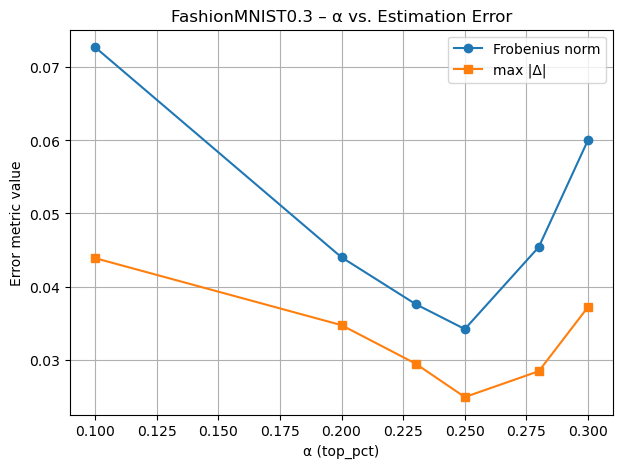

In [14]:
import matplotlib.pyplot as plt
alphas = [0.1, 0.2, 0.23, 0.25, 0.28, 0.3]
frobs, maxabs = [], []

P_1 = best_anchor_1.predict_proba(X_1_std)   # use your best anchor model
for a in alphas:
    T_hat_1, _ = estimate_T_from_probs(P_1, y_1, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_1 - T_true_03
    frob = np.linalg.norm(diff, 'fro')
    max_a = np.max(np.abs(diff))
    frobs.append(frob)
    maxabs.append(max_a)
    print(f"α={a:.2f} | fro={frob:.4f} | max|Δ|={max_a:.4f}")

# ---------- Visualization ----------
plt.figure(figsize=(7, 5))
plt.plot(alphas, frobs, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.3 – α vs. Estimation Error")
plt.legend()
plt.grid(True)
plt.show()

α=0.10 | fro=0.0973 | max|Δ|=0.0672
α=0.20 | fro=0.0465 | max|Δ|=0.0336
α=0.25 | fro=0.0377 | max|Δ|=0.0242
α=0.28 | fro=0.0331 | max|Δ|=0.0170
α=0.30 | fro=0.0284 | max|Δ|=0.0128
α=0.32 | fro=0.0323 | max|Δ|=0.0158
α=0.35 | fro=0.0316 | max|Δ|=0.0152
α=0.40 | fro=0.0423 | max|Δ|=0.0231


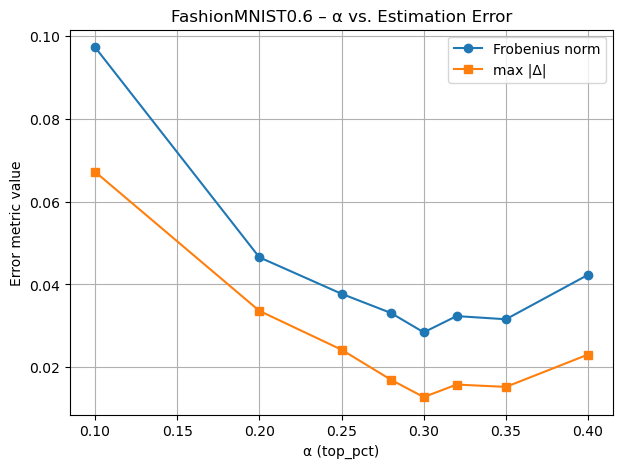

In [15]:
P_2 = best_anchor_2.predict_proba(X_2_std)

alphas = [0.1,0.2,0.25, 0.28,0.3,0.32,0.35,0.4]
frobs, maxabs = [], []

for a in alphas:
    T_hat_2, _ = estimate_T_from_probs(P_2, y_2, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_2 - T_true_06
    frob = np.linalg.norm(diff, 'fro')
    max_a = np.max(np.abs(diff))
    frobs.append(frob); maxabs.append(max_a)
    print(f"α={a:.2f} | fro={frob:.4f} | max|Δ|={max_a:.4f}")

# plot
plt.figure(figsize=(7,5))
plt.plot(alphas, frobs, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.6 – α vs. Estimation Error")
plt.legend(); plt.grid(True); plt.show()

# 5 估计CIFAR的T

In [16]:
alphas = [0.28, 0.30, 0.32, 0.35]
min_per_class = int(0.005 * len(y_3))

P3 = best_anchor_3.predict_proba(X_3_std)

def pick_alpha(probs, y, alphas):
    best = None
    for a in alphas:
        T_hat, anchors = estimate_T_from_probs(probs, y, top_pct=a, use_counts=True, verbose=False)
        cnts = [len(ix) for ix in anchors]
        if min(cnts) < min_per_class:
            continue
        diag_mean = float(np.diag(T_hat).mean())
        cand = (diag_mean, -a, T_hat)  
        if (best is None) or (cand > best[:3]):
            best = (*cand, a)
    return best  # (diag_mean, -alpha, T_hat, alpha)

best = pick_alpha(P3, y_3, alphas)
chosen_alpha = 0.30 if best is None else best[-1]
print(f"Chosen alpha for CIFAR: {chosen_alpha:.2f}")
T_hat_3 = (best[2] if best else estimate_T_from_probs(P3, y_3, top_pct=0.30, use_counts=True, verbose=False)[0])
print(np.round(T_hat_3, 4))


Chosen alpha for CIFAR: 0.28
[[0.38   0.296  0.324 ]
 [0.3443 0.3619 0.2938]
 [0.2995 0.3243 0.3762]]
